<a href="https://colab.research.google.com/github/masrik-dev/food-image-recognition/blob/main/food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Food Vision Big Classifier**

## **Introduction**

This project focuses on developing a machine learning model for classifying types of food from photographs. The goal is to build a robust image classification system capable of accurately identifying different food categories based on visual features. To train and evaluate the model, we utilized the Food-101 dataset, a comprehensive collection of food images sourced from Kaggle. This dataset comprises 101 distinct classes of food, providing a diverse and challenging benchmark for training and testing the model's performance.

>  ***Due to its large size, the dataset was imported from TensorFlow Datasets (TFDS)***


*Download data here:* https://www.kaggle.com/datasets/dansbecker/food-101

# Check GPU and TensorFlow version.

In [ ]:
# Are we using a GPU?
# If not, and you're in Google Colab, go to Runtime -> Change runtime type -> Hardware accelerator -> GPU
!nvidia-smi

In [1]:
# Check TensorFlow version
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

TensorFlow version: 2.19.0
Notebook last run (end-to-end): 2025-09-14 18:17:38.549325


# Import helper_function.py file

Import helper_functions.py, which includes utility functions such as:
`load_and_prep_image, make_confusion_matrix, pred_and_plot, plot_loss_curves, and calculate_results.`

These will assist with model evaluation, data preprocessing, and result visualization.


In [1]:
!wget https://raw.githubusercontent.com/masrik-dev/food-image-recognition/refs/heads/main/helper_function.py

--2025-09-15 07:02:51--  https://raw.githubusercontent.com/masrik-dev/food-image-recognition/refs/heads/main/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7168 (7.0K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]   7.00K  --.-KB/s    in 0s      

2025-09-15 07:02:51 (15.7 MB/s) - ‘helper_function.py’ saved [7168/7168]



In [2]:
# Import series of helper functions for the notebook
from helper_function import load_and_prep_image, make_confusion_matrix, pred_and_plot, plot_loss_curves, calculate_results

# Use TensorFlow Datasets (TFDS) to Download Data

In [2]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


In [3]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [4]:
# Feature of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [5]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 data from TensorFlow Datasets

In [6]:
# Take one sample off the training data
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
# Output info about training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 384, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 19
  Class name (str form): chicken_quesadilla
        


In [8]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 384, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  7,   7,   5],
        [ 11,  11,   9],
        [ 14,  14,  12]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  5,   5,   3],
        [  8,   8,   6],
        [ 11,  11,   9]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  5,   5,   3],
        [  7,   7,   5],
        [ 10,  10,   8]],

       ...,

       [[ 72,  75,  82],
        [ 55,  58,  65],
        [ 43,  46,  51],
        ...,
        [105, 113, 115],
        [108, 113, 116],
        [135, 140, 143]],

       [[ 75,  80,  86],
        [ 61,  66,  72],
        [ 51,  54,  59],
        ...,
        [102, 107, 110],
        [ 75,  79,  82],
        [111, 115, 118]],

       [[ 94,  99, 105],
        [ 81,  86,  92],
        [ 71,  74,  79],
        ...,
        [151, 156, 15

In [9]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

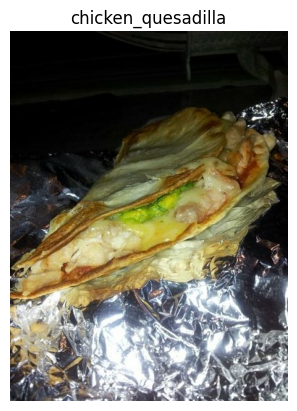

In [10]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

In [11]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'unit8' -> 'float32' and reshapes image to
  [img_shape, imag_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [12]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 7  7  5]
  [11 11  9]
  [14 14 12]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 5  5  3]
  [ 8  8  6]
  [11 11  9]]]...,
Shape: (512, 384, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  ...
  [ 7.7907934  7.7907934  5.7907934]
  [ 5.714286   5.714286   3.7142856]
  [10.999987  10.999987   8.999987 ]]

 [[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  ...
  [ 6.770399   6.770399   4.770399 ]
  [ 6.790833   6.790833   4.790833 ]
  [10.1887665 10.1887665  8.1887665]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


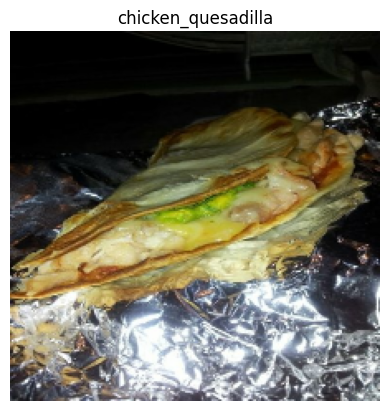

In [13]:
# Plot preprocessed image by divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## Batch and Prepare datasets

In [14]:

# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [16]:
# Let's figure out the image batch shape, and labels batch shape
for images, lbls in train_data.take(1):
    print("Image batch shape:", images.shape)
    print("Labels batch shape:", lbls.shape)

Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32,)


## Create a ModelCheckpoint

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoint/cp.weights.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   monitor="val_accuracy",
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=0)

## Setup mixed precision training

In [18]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [19]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

# Build feature extraction model

## Model_1 : feature extraction model using `EfficientNetB0`

In [22]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if the model didn't we could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalMaxPooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

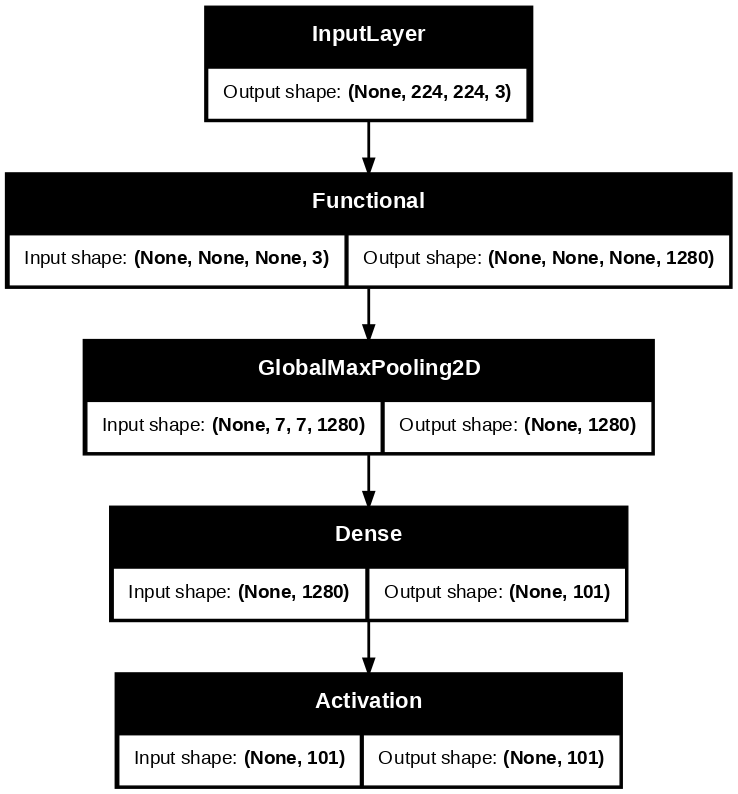

In [23]:
# Plot the tribid model
from keras.utils import plot_model
plot_model(model_1, show_shapes=True, dpi=100)

### Fit model_1

In [25]:
# Fit the model
history_model_1 = model_1.fit(train_data,
                          epochs=3,
                          steps_per_epoch=int(0.15 * len(train_data)),
                          validation_data=test_data,
                          validation_steps=int(0.15 * len(test_data)),
                          callbacks=[model_checkpoint])

Epoch 1/3
355/355 ━━━━━━━━━━━━━━━━━━━━ 5382s 15s/step - accuracy: 0.2199 - loss: 4.6419 - val_accuracy: 0.4224 - val_loss: 2.9180
Epoch 2/3
355/355 ━━━━━━━━━━━━━━━━━━━━ 5354s 15s/step - accuracy: 0.3966 - loss: 3.3251 - val_accuracy: 0.4762 - val_loss: 2.7666
Epoch 3/3
355/355 ━━━━━━━━━━━━━━━━━━━━ 5364s 15s/step - accuracy: 0.4477 - loss: 3.2078 - val_accuracy: 0.5305 - val_loss: 2.3865


### Check model's history on plots

In [ ]:
# Function to plot loss and accuracy curves
plot_loss_curves(history_model_1)

### Evaluate model on full test data

In [ ]:
model_1.evaluate(test_data)

### Making predictions with the trained model 1

In [ ]:
# Make predictions with model
pred_probs = model_1.predict(test_data, verbose=1)

In [ ]:
# How many predictions are there, and what is the shape of the predictions
len(pred_probs), pred_probs.shape

In [ ]:
# How do they look
pred_probs[:10]

In [ ]:
# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

To retrieve the test dataset labels, unravel the `test_data` (a `tf.data.Dataset` object) by using the `unbatch()` method.

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

In [ ]:
# Get the class names
class_names = test_data.class_names
class_names

### Confusion matrix

In [ ]:
# Plot the confusion matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

## Save and load the model

In [ ]:
model_1.save("models/food_vision_model_1.keras")

In [ ]:
loaded_model_1 = tf.keras.models.load_model("models/food_vision_model_1.keras")

# Rebuild a model

What to do:

1. Try EfficientNetB1 instead of EfficientNetB0
2. Enable Fine-Tuning (unfreeze last 10 layers of EfficientNetB1)
3. Experiment with Batch Normalization
4. Add More Fully Connected (Dense) Layers
5. Experiment with Batch Normalization
6. Decrease the learning rate of optimizer
7. Change `steps_per_epoch` and `validation_steps` in model fitting.

## Model checkpoint and mixed precision training

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import mixed_precision

# Define the checkpoint path
checkpoint_path = "model_checkpoints/model_2/cp.weights.h5"
# Create a model checkpoint callback
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)
# Enable mixed precision
mixed_precision.set_global_policy(policy="mixed_float16")

## Build model 2

In [ ]:
from tensorflow.keras import layers

# Switch to EfficientNetB1
base_model = tf.keras.applications.EfficientNetB1(include_top=False)

# Unfreeze the last 10 layers (fewer layers for finetuning to reduce training time)
for layer in base_model.layers[-10:]:
  layer.trainable = True

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

# EfficientNet and additional layers
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="avg_pool")(x) # Efficient feature extraction
x = layers.BatchNormalization(name="batch_norm")(x)
x = layers.Dense(128, activation="relu", name="dense_layer_1")(x) # Reduced to 128 neurons
x = layers.Dropout(0.2, name="dropout_1")(x) # Lower dropout to reduce computation
x = layers.Dense(len(class_names), name="output_dense")(x) # Final layer for classification
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax")(x)

# Compile the model
model_2 = tf.keras.Model(inputs, outputs)

# Use mixed precision optimizer
optimizer = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=0.0001))
model_2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [ ]:
# Plot the tribid model
from keras.utils import plot_model
plot_model(model_2, show_shapes=True, dpi=100)

### Fit the second model

In [ ]:
history_model_2 = model_2.fit(train_data,
                              epochs=5,
                              steps_per_epoch=int(0.15*len(train_data)),
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=[model_checkpoint])

### Review the plot history of the second model

In [ ]:
plot_loss_curves(history_model_2)

### Evaluate second model on the full test data

In [ ]:
model_2.evaluate(test_data)

### Making predictions with the trained model 2

In [ ]:
# Make predictions with model
pred_probs_2 = model_2.predict(test_data, verbose=1)

In [ ]:
# How many predictions are there, and what is the shape of the predictions
len(pred_probs_2), pred_probs_2.shape

In [ ]:
# How do they look
pred_probs_2[:10]

In [ ]:
# Get the class predictions of each label
pred_classes_2 = pred_probs_2.argmax(axis=1)
pred_classes_2[:10]

### Confusion matrix of model 2

In [ ]:
# Plot the confusion matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes_2,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

## Save and load second model

In [ ]:
model_2.save("models/food_vision_model_2.keras")

In [ ]:
from tensorflow.keras.models import load_model
loaded_model_2 = load_model("models/food_vision_model_2.keras")

# To do

Try another way of approaching model design:

1. Try a CNN architecture to build a model
2. Increase the training dataset
3. Expand the number of layers
4. Increase the number of neurons
5. Increase the number of epochs
6. Early Stopping: Stops training if validation accuracy does not improve for a specified number of epochs.
7. Learning Rate Scheduler: Dynamically adjusts the learning rate when validation accuracy plateaus.

## Callbacks and mixed precision for model 3

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import mixed_precision
from tensorflow.keras import callbacks, optimizers

# Define the checkpoint path
checkpoint_path = "model_checkpoints/model_3/cp.weights.h5"

# Callbacks
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Enable mixed precision
mixed_precision.set_global_policy(policy="mixed_float16")

## Model 3: Build and Fit

In [ ]:
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.layers import BatchNormalization

# Input layer
input_layer = layers.Input(shape=(224, 224, 3), name="input_layer")
x = input_layer

# Block 1
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

# Block 2
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

# Block 3
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

# Residual Block 4
residual = layers.Conv2D(256, (1, 1), padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

# Global Average Pooling and Dense layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)

# Model definition
model_3 = Model(inputs=input_layer, outputs=output_layer, name="food_classification_model_3")

# Compile the model
model_3.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

In [ ]:
# Fit the model 3
history_model_3 = model_3.fit(train_data,
                              epochs=30,
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=[model_checkpoint, early_stopping, lr_scheduler])

### Model 3 Evaluation and Loss curves

In [ ]:
model_3.evaluate(test_data)

In [ ]:
plot_loss_curves(history_model_3)

### Making predictions with the trained model 3


In [ ]:
# Make predictions with model
pred_probs_3 = model_3.predict(test_data, verbose=1)

In [ ]:
# How many predictions are there, and what is the shape of the predictions
len(pred_probs_3), pred_probs_3.shape

In [ ]:
# How do they look
pred_probs_3[:10]

In [ ]:
# Get the class predictions of each label
pred_classes_3 = pred_probs_3.argmax(axis=1)
pred_classes_3[:10]

### Confusion matrix of model 2

In [ ]:
# Plot the confusion matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes_3,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

## Save and load model

In [ ]:
model_3.save("models/food_vision_model_3.keras")

In [ ]:
from tensorflow.keras.models import load_model
loaded_model_3 = load_model("models/food_vision_model_3.keras")

# Model 4: EfficientNetB1 with 10 epochs

## Build and fit model 4

** Difference with model 2:**
1. Increase epochs to 10
2. Give tensorflow opportunity automatically identify `steps_per_epoch` and `validation_steps`

Callbacks and mixed precision are the same as in model 3

In [ ]:
from tensorflow.keras import layers
# base model of EfficientNetB1
base_model = tf.keras.applications.EfficientNetB1(include_top=False)

# Unfreeze the last 10 layers (same as model 2)
for layer in base_model.layers[-10:]:
  layer.trainable = True

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

# EfficientNet and additional layers
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)  # Efficient feature extraction
x = layers.BatchNormalization(name="batch_norm")(x)
x = layers.Dense(128, activation="relu", name="dense_layer_1")(x) # Reduced to 128 neurons
x = layers.Dropout(0.2, name="dropout_1")(x)   # Lower dropout to reduce computation
x = layers.Dense(len(class_names), name="output_dense")(x)  # Final layer for classification
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax")(x)

# Compile the model
model_4 = tf.keras.Model(inputs, outputs)

# Use mixed precision optimizer
optimizer = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=0.0001))
model_4.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)


In [ ]:
# Fit the model 4
history_model_4 = model_4.fit(train_data,
                              epochs=10,
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=[model_checkpoint, early_stopping, lr_scheduler])

### Model 4 Evaluation and Loss curves

In [ ]:
model_4.evaluate(test_data)

In [ ]:
plot_loss_curves(history_model_4)

### Making predictions with the trained model 4

In [ ]:
# Make predictions with model
pred_probs_4 = model_4.predict(test_data, verbose=1)

In [ ]:
# How many predictions are there, and what is the shape of the predictions
len(pred_probs_4), pred_probs_4.shape

In [ ]:
# How do they look
pred_probs_4[:10]

In [ ]:
# Get the class predictions of each label
pred_classes_4 = pred_probs_4.argmax(axis=1)
pred_classes_4[:10]

### Confusion matrix of model 2

In [ ]:
# Plot the confusion matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes_4,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

## Save and load model 4

In [ ]:
model_4.save("models/food_vision_model_4.keras")

In [ ]:
from tensorflow.keras.models import load_model
loaded_model_4 = load_model("models/food_vision_model_4.keras")

## Compare the results of 4 models on new data

### Upload photos from local file to test model

In [3]:
from google.colab import files

# This will open a file picker
uploaded = files.upload()

Saving image.zip to image.zip


In [4]:
import zipfile

# Extract the uploaded zip
zip_filename = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("uploaded_photos")

print("Extracted photos to 'uploaded_photos/'")

Extracted photos to 'uploaded_photos/'


In [6]:
import tensorflow as tf
import os

# Make test_photos folder
os.makedirs("test_photos", exist_ok=True)

# Go through uploaded images, resize, and save as JPG
for i, filename in enumerate(os.listdir("uploaded_photos")):
  if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
    img = tf.io.read_files(os.path.join("uploaded_photos", filename))
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [224, 224])  # resize for model
    img_bytes = tf.io.encode_jpeg(tf.cast(img, tf.uint8))
    tf.io.write_file(f"test_photos/img_{i}.jpg", img_bytes)

print("Saved all uploaded images into 'test_photos/")

Saved all uploaded images into 'test_photos/


In [7]:
# Make photo path to push it in the testing
test_photo_paths = [os.path.join("test_photos", fname) for fname in os.listdir("test_photos")]

### Compare models with uploaded photos

In [ ]:
import os
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

model_paths = {
    "EfficientNetB0": "models/food_vision_model_1.keras",
    "EfficientNetB1 (5 epochs)": "models/food_vision_model_2.keras",
    "CNN": "models/food_vision_model_3.keras",
    "EfficientNetB1 (10 epochs)": "models/food_vision_model_4.keras"
}

test_photos_dir = "test_photos"

label_encoder = LabelEncoder()
label_encoder.classes_ = np.load("models/label_classes.npy")

def preprocess_image(image_path, img_size=(224, 224), model_path=None):
  img = image.load_img(image_path, target_size=img_size)
  img_array = image.img_to_array(img)
  img_array = tf.expand_dims(img_array, axis=0)
  if model_path == "models/food_vision_model_3.keras":  # EfficientNetBX makes scaling automatically
    img_array = img_array / 255.
  return img_array

def predict_food_type_with_confidence(model, model_path, image_path):
  img_array = preprocess_image(image_path, model_path=model_path)
  predictions = model.predict(img_array, verbose=0)
  predicted_label_idx = np.argmax(predictions, axis=1)[0]
  confidence = predictions[0][predicted_label_idx]
  food_type = label_encoder.inverse_transform([predicted_label_idx])
  return food_type[0], confidence

models = {name: load_model(path, compile=False) for name, path in model_paths.items()}

test_photo_paths = [os.path.join(test_photos_dir, fname) for fname in os.listdir(test_photos_dir)]

fig, axes = plt.subplots(len(models), len(test_photo_paths), figsize=(20, 10))
fig.suptitle("Model Predictions Comparison", fontsize=16)

for j, model_name in enumerate(models.keys()):
  axes[0, j].set_title(model_name, fontsize=12)

for j, (model_name, model_paths) in enumerate(model_paths.items()):
  for i, photo_path in enumerate(test_photo_paths):
    predicted_food, confidence = predict_food_type_with_confidence(models[model_name], model_path, photo_path)
    img = image.load_img(photo_path)
    axes[j, i].imshow(img)
    axes[j, i].axis('off')
    axes[j, i].set_title(f"{predicted_food} ({confidence:.2%})", fontsize=12)
plt.show()

# Final Model

In [ ]:
from tensoflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import mixed_precision
from tensorflow.keras import callbacks, optimizers
checkpoint_path = "model_checkpoints/final_model/cp.weights.h5"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
mixed_precision.set_global_policy(policy="mixed_float16")

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBx models have rescaling built-in.
# x = layers.Rescaling(1/255.)(x)  # rescaling layer
x = base_model(inputs, training=False)  # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)  # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
final_model = tf.keras.Model(inputs, outputs)


# Compile the model
final_model.compile(loss="sparse_categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [ ]:
history_model_final = final_model.fit(train_data,
                                      epochs=3,
                                      validation_data=test_data,
                                      callbacks=[model_checkpoint])

In [ ]:
from tensorflow.keras.models import clone_model
final_model_2 = clone_model(final_model)
final_model_2.load_weights("model_checkpoints/final_model/cp.weights.h5")
final_model_2.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

history_new_model = final_model_2.fit(train_data,
                                     epochs=2,
                                     validation_data=test_data,
                                     callbacks=[model_checkpoint])

In [ ]:
final_model_2.save("final_model.keras")